In [1]:
import pandas as pd

df = pd.read_csv('/kaggle/input/techendata/united_divided.csv')
print(df.head(3))

                                          image_link  temperature  \
0  https://cdn.pixabay.com/photo/2020/10/03/11/08...          0.8   
1  https://cdn.pixabay.com/photo/2021/11/16/11/13...          1.0   
2  https://cdn.pixabay.com/photo/2016/10/25/15/14...          0.7   

                                         description  \
0   The image features a woman holding out her ha...   
1   In a camping scene, a man is sitting outside ...   
2  <0x0A>The image captures a cozy and inviting s...   

                                              logits  \
0  [(' The', {'The': 0.6002, 'In': 0.3314, 'A': 0...   
1  [(' In', {'The': 0.7592, 'In': 0.1642, 'A': 0....   
2  [('<0x0A>', {'<0x0A>': 0.9769598245620728, ' T...   

                                      hallucinations  \
0  The image features a woman holding out her han...   
1  In a camping scene, a man is sitting outside a...   
2                                                NaN   

                                              he

In [2]:
from transformers import AutoProcessor

# Load the processor
processor = AutoProcessor.from_pretrained('llava-hf/llava-1.5-7b-hf')

# Access the tokenizer
tokenizer = processor.tokenizer

2024-08-09 19:57:21.028438: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 19:57:21.028571: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 19:57:21.180171: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Using Geometric average:

In [40]:
import math

true_lst = []
false_lst = []
problematic_lst = []
for index, row in df.iterrows():
    print(index, end='\r')
    for i in range(1,5):
        label = row[f'label_{i}']
        probe = row[f'probe_{i}']
        if '[' not in row[f'context_{i}']:
            problematic_lst.append([index, i, row['temperature']])
        else:
            context = tokenizer.encode(row[f'context_{i}'].split('[')[1].split(']')[0], add_special_tokens=False)
            context = [tokenizer.decode(item, skip_special_tokens=True) for item in context]
            logits = row['logits'].replace('[', '').replace(']','').split('), (')
            logits = [item for innerlst in logits for item in innerlst.split('},')]
            for start_index, logit in enumerate(logits):
                flag = False
                chosen_word = logit.split(', {')[0]
                if context[0] == chosen_word.strip("' ()"):
                    logits_mul = []
                    logits_add = []
                    skip_flag = 0
                    skips = 0
                    for j, cont_logit in enumerate(context):
                        if skip_flag == 0:
                            curr_logit = logits[start_index+j-skips].split(', {')[0].strip("' ()")
                            if cont_logit != curr_logit:
                                if not curr_logit.startswith(cont_logit):
                                    break
                                if cont_logit == '' and j == len(context)-1:
                                    flag = True
                                    break
                                if curr_logit != cont_logit + context[j+1]:
                                    skip_flag = 2
                                else:
                                    skip_flag = 1
                            logits_add.append(curr_logit)
                            logits_mul.append(float(logits[start_index+j-skips].strip('"()').replace(' ','').split(f"'{curr_logit}':")[1].split(',')[0].strip('{}')))
                        else:
                            skips += 1
                            skip_flag -= 1
                        if j == len(context)-1:
#                             if len(context) != len(logits_mul):
#                                 print(context)
#                                 print(logits_add)
                            flag = True

                if flag:
                    break
            if label:
                true_lst.append(math.prod(logits_mul)**(1/len(logits_mul)))
            else:
                false_lst.append(math.prod(logits_mul)**(1/len(logits_mul)))

In [41]:
print(sum(true_lst)/len(true_lst))
print(sum(false_lst)/len(false_lst))

0.46887691131278225
0.41469109783936164


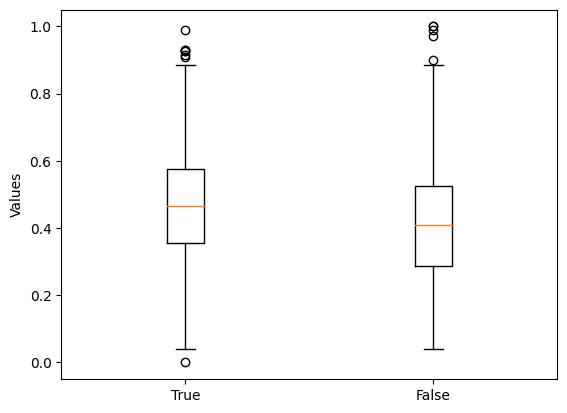

In [42]:
import matplotlib.pyplot as plt


data = [true_lst, false_lst]

plt.boxplot(data, labels=['True', 'False'])

plt.ylabel('Values')

# Show the plot
plt.show()


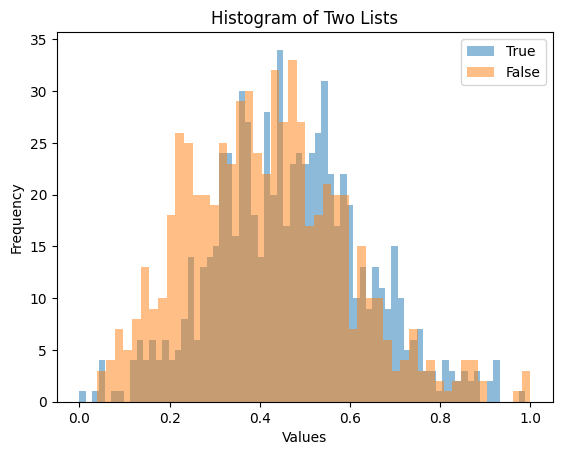

In [43]:
import matplotlib.pyplot as plt


plt.hist(true_lst, bins=70, alpha=0.5, label='True')
plt.hist(false_lst, bins=50, alpha=0.5, label='False')

# Add title and labels
plt.title('Histogram of Two Lists')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Add a legend
plt.legend()

# Show the plot
plt.show()


# We'll try to take the model prediction into consideration as well:

In [35]:
import math

true_lst = []
false_lst = []
problematic_lst = []
for index, row in df.iterrows():
    print(index, end='\r')
    for i in range(1,5):
        label = row[f'label_{i}']
        probe = row[f'probe_{i}']
        if '[' not in row[f'context_{i}']:
            problematic_lst.append([index, i, row['temperature']])
        else:
            context = tokenizer.encode(row[f'context_{i}'].split('[')[1].split(']')[0], add_special_tokens=False)
            context = [tokenizer.decode(item, skip_special_tokens=True) for item in context]
            logits = row['logits'].replace('[', '').replace(']','').split('), (')
            logits = [item for innerlst in logits for item in innerlst.split('},')]
            for start_index, logit in enumerate(logits):
                flag = False
                chosen_word = logit.split(', {')[0]
                if context[0] == chosen_word.strip("' ()"):
                    logits_mul = []
                    logits_add = []
                    skip_flag = 0
                    skips = 0
                    for j, cont_logit in enumerate(context):
                        if skip_flag == 0:
                            curr_logit = logits[start_index+j-skips].split(', {')[0].strip("' ()")
                            if cont_logit != curr_logit:
                                if not curr_logit.startswith(cont_logit):
                                    break
                                if cont_logit == '' and j == len(context)-1:
                                    flag = True
                                    break
                                if curr_logit != cont_logit + context[j+1]:
                                    skip_flag = 2
                                else:
                                    skip_flag = 1
                            logits_add.append(curr_logit)
                            logits_mul.append(float(logits[start_index+j-skips].strip('"()').replace(' ','').split(f"'{curr_logit}':")[1].split(',')[0].strip('{}')))
                        else:
                            skips += 1
                            skip_flag -= 1
                        if j == len(context)-1:
#                             if len(context) != len(logits_mul):
#                                 print(context)
#                                 print(logits_add)
                            flag = True

                if flag:
                    break
            if label:
                true_lst.append(math.prod(logits_mul)**(1/len(logits_mul))*row[f'pred_{i}'])
            else:
                false_lst.append(math.prod(logits_mul)**(1/len(logits_mul))*row[f'pred_{i}'])

In [36]:
print(sum(true_lst)/len(true_lst))
print(sum(false_lst)/len(false_lst))

0.3492753375538745
0.2884053969478697


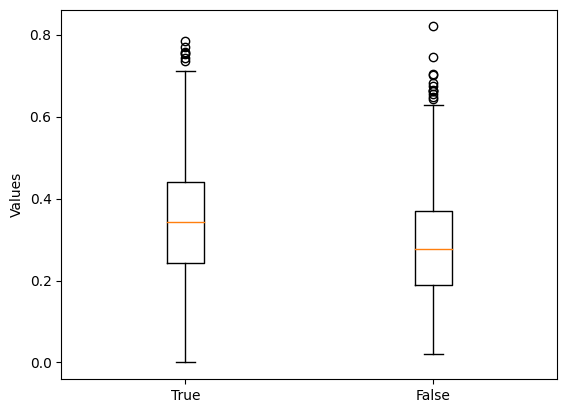

In [37]:
import matplotlib.pyplot as plt


data = [true_lst, false_lst]

plt.boxplot(data, labels=['True', 'False'])

plt.ylabel('Values')

# Show the plot
plt.show()


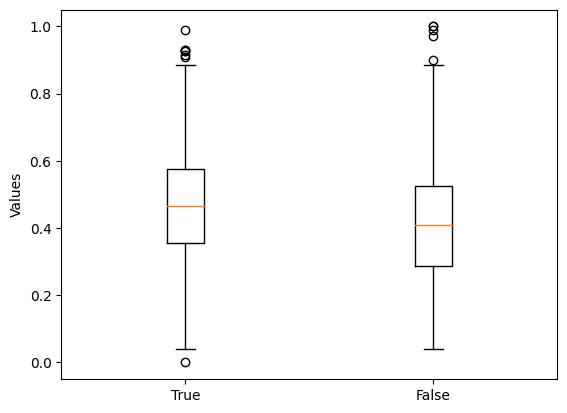

In [46]:
# Plot of without taking the preds into consideration

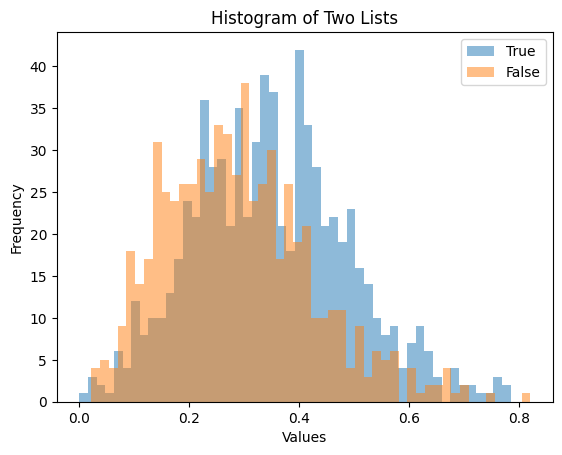

In [39]:
import matplotlib.pyplot as plt


plt.hist(true_lst, bins=50, alpha=0.5, label='True')
plt.hist(false_lst, bins=50, alpha=0.5, label='False')

# Add title and labels
plt.title('Histogram of Two Lists')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Add a legend
plt.legend()

# Show the plot
plt.show()


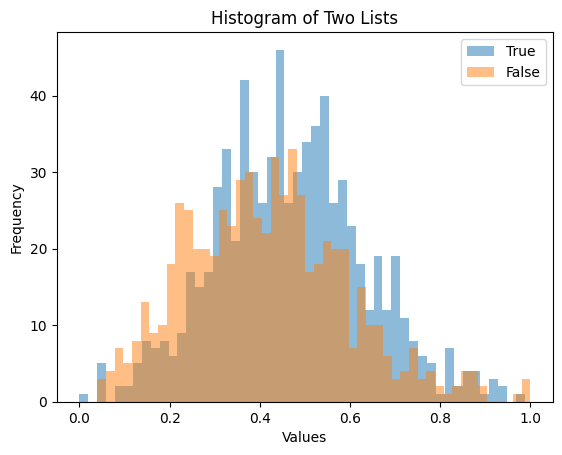

In [45]:
# Plot of without taking the preds into consideration

# Using harmonic average:

In [31]:
import statistics

true_lst = []
false_lst = []
problematic_lst = []
for index, row in df.iterrows():
    print(index, end='\r')
    for i in range(1,5):
        label = row[f'label_{i}']
        probe = row[f'probe_{i}']
        if '[' not in row[f'context_{i}']:
            problematic_lst.append([index, i, row['temperature']])
        else:
            context = tokenizer.encode(row[f'context_{i}'].split('[')[1].split(']')[0], add_special_tokens=False)
            context = [tokenizer.decode(item, skip_special_tokens=True) for item in context]
            logits = row['logits'].replace('[', '').replace(']','').split('), (')
            logits = [item for innerlst in logits for item in innerlst.split('},')]
            for start_index, logit in enumerate(logits):
                flag = False
                chosen_word = logit.split(', {')[0]
                if context[0] == chosen_word.strip("' ()"):
                    logits_mul = []
                    logits_add = []
                    skip_flag = 0
                    skips = 0
                    for j, cont_logit in enumerate(context):
                        if skip_flag == 0:
                            curr_logit = logits[start_index+j-skips].split(', {')[0].strip("' ()")
                            if cont_logit != curr_logit:
                                if not curr_logit.startswith(cont_logit):
                                    break
                                if cont_logit == '' and j == len(context)-1:
                                    flag = True
                                    break
                                if curr_logit != cont_logit + context[j+1]:
                                    skip_flag = 2
                                else:
                                    skip_flag = 1
                            logits_add.append(curr_logit)
                            logits_mul.append(float(logits[start_index+j-skips].strip('"()').replace(' ','').split(f"'{curr_logit}':")[1].split(',')[0].strip('{}')))
                        else:
                            skips += 1
                            skip_flag -= 1
                        if j == len(context)-1:
#                             if len(context) != len(logits_mul):
#                                 print(context)
#                                 print(logits_add)
                            flag = True

                if flag:
                    break
            if label:
                true_lst.append(statistics.harmonic_mean(logits_mul))
            else:
                false_lst.append(statistics.harmonic_mean(logits_mul))

In [32]:
print(sum(true_lst)/len(true_lst))
print(sum(false_lst)/len(false_lst))

0.32463394512370186
0.26603760058572207


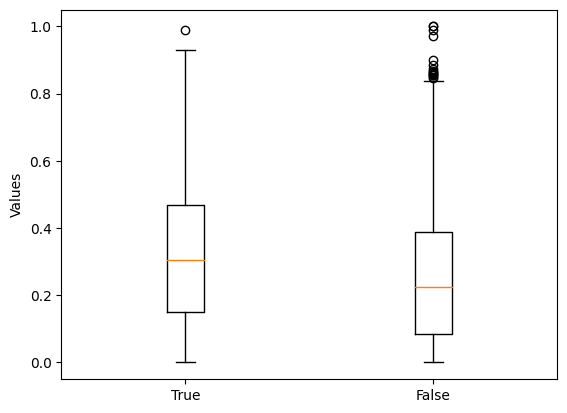

In [33]:
import matplotlib.pyplot as plt


data = [true_lst, false_lst]

plt.boxplot(data, labels=['True', 'False'])

plt.ylabel('Values')

# Show the plot
plt.show()


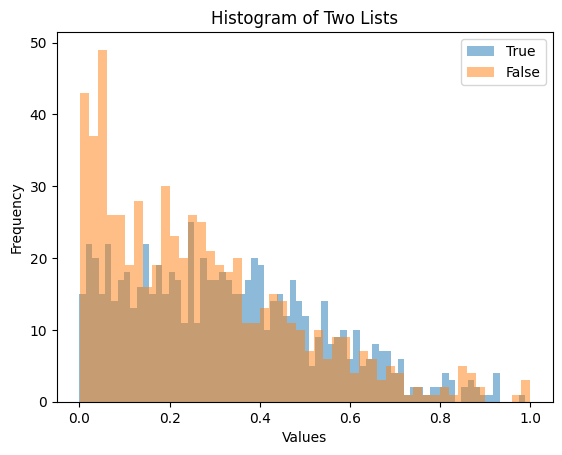

In [34]:
import matplotlib.pyplot as plt


plt.hist(true_lst, bins=70, alpha=0.5, label='True')
plt.hist(false_lst, bins=50, alpha=0.5, label='False')

# Add title and labels
plt.title('Histogram of Two Lists')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Add a legend
plt.legend()

# Show the plot
plt.show()


# Using arithmetic average:

In [26]:
import math

true_lst = []
false_lst = []
problematic_lst = []
for index, row in df.iterrows():
    print(index, end='\r')
    for i in range(1,5):
        label = row[f'label_{i}']
        probe = row[f'probe_{i}']
        if '[' not in row[f'context_{i}']:
            problematic_lst.append([index, i, row['temperature']])
        else:
            context = tokenizer.encode(row[f'context_{i}'].split('[')[1].split(']')[0], add_special_tokens=False)
            context = [tokenizer.decode(item, skip_special_tokens=True) for item in context]
            logits = row['logits'].replace('[', '').replace(']','').split('), (')
            logits = [item for innerlst in logits for item in innerlst.split('},')]
            for start_index, logit in enumerate(logits):
                flag = False
                chosen_word = logit.split(', {')[0]
                if context[0] == chosen_word.strip("' ()"):
                    logits_mul = []
                    logits_add = []
                    skip_flag = 0
                    skips = 0
                    for j, cont_logit in enumerate(context):
                        if skip_flag == 0:
                            curr_logit = logits[start_index+j-skips].split(', {')[0].strip("' ()")
                            if cont_logit != curr_logit:
                                if not curr_logit.startswith(cont_logit):
                                    break
                                if cont_logit == '' and j == len(context)-1:
                                    flag = True
                                    break
                                if curr_logit != cont_logit + context[j+1]:
                                    skip_flag = 2
                                else:
                                    skip_flag = 1
                            logits_add.append(curr_logit)
                            logits_mul.append(float(logits[start_index+j-skips].strip('"()').replace(' ','').split(f"'{curr_logit}':")[1].split(',')[0].strip('{}')))
                        else:
                            skips += 1
                            skip_flag -= 1
                        if j == len(context)-1:
#                             if len(context) != len(logits_mul):
#                                 print(context)
#                                 print(logits_add)
                            flag = True

                if flag:
                    break
            if label:
                true_lst.append(sum(logits_mul)/len(logits_mul))
            else:
                false_lst.append(sum(logits_mul)/len(logits_mul))

In [27]:
print(sum(true_lst)/len(true_lst))
print(sum(false_lst)/len(false_lst))

0.5990556126454131
0.5625407370232716


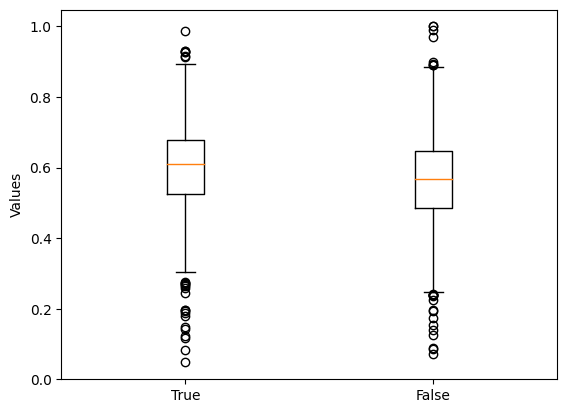

In [28]:
import matplotlib.pyplot as plt


data = [true_lst, false_lst]

plt.boxplot(data, labels=['True', 'False'])

plt.ylabel('Values')

# Show the plot
plt.show()


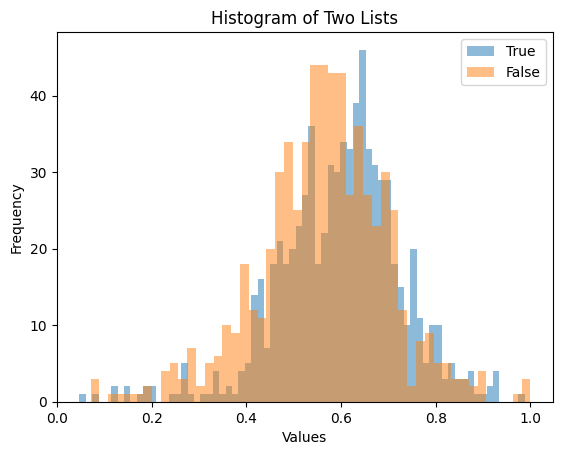

In [29]:
import matplotlib.pyplot as plt


plt.hist(true_lst, bins=70, alpha=0.5, label='True')
plt.hist(false_lst, bins=50, alpha=0.5, label='False')

# Add title and labels
plt.title('Histogram of Two Lists')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Add a legend
plt.legend()

# Show the plot
plt.show()


# There were some probes without marked context. 
The format - [image ID, probe num, temperature]

By the temperature we can see that it's the other team fault (ours was constant 0.7).

In [30]:
print(problematic_lst)

[[58, 1, 1.0], [58, 2, 1.0], [58, 3, 1.0], [58, 4, 1.0], [138, 1, 1.0], [138, 2, 1.0], [138, 3, 1.0], [138, 4, 1.0], [171, 1, 1.0], [171, 2, 1.0], [171, 3, 1.0], [171, 4, 1.0], [229, 3, 0.8], [243, 1, 0.8], [243, 2, 0.8], [243, 3, 0.8], [243, 4, 0.8], [269, 3, 0.9]]
